# Notebook 4 - Extracting Data from the DABO Well Database

[GemGIS](https://github.com/cgre-aachen/gemgis) is a package for geographic information processing for geomodeling. In particular, data is prepared for direct use in [GemPy](https://github.com/cgre-aachen/gempy) via a GemPy Data Class. The package provides functions to process spatial data such as vector data (shape files, geojson files, geopackages), raster data (tiff-files), data retrieved from online services (WMS, WCS, WFS) or KML/XML files. 

At a later stage, functionality will be added to interactively add interfaces and orientations for a model, chosing the extent, defining custom sections and more. In addition, functionality will be provided to export data from GemPy into Geoinformation Systems (=GIS) such as QGIS or ArcGIS and Google Earth. 

# Overview

This notebook presents the interpolation of isolines to form a first representation of the Top Carboniferous in the Münster Basin (neglecting faults) and the preparation of interface points for the interpolation with `GemPy`, which will be performed subsequently. The data is available at https://www.opengeodata.nrw.de/produkte/geologie/geologie/SP/grosstekruhr/. 

- [Downloading and Installing GemGIS](#gemgis)
- [Structure of GemGIS](#structure)
- [Importing Libraries](#import)
- [Version Reports](#vreport)


<a id='gemgis'></a>
## Downloading and installing GemGIS

`GemGIS` is under constant development and the latest available version can be downloaded at https://github.com/cgre-aachen/gemgis. A pip version can be found at https://pypi.org/project/gemgis/. A dedicated documentation page will follow.

<a id='structure'></a>
## Structure of GemGIS

The core of `GemGIS` is made of the `GemPyData` class (`gemgis.py`). Its attributes can directly be utilized by `GemPy` making it easier for users to load data. Methods of the `GemPyData` class allow users to directly set these attributes. Multiple other files contain functions to manipulate vector data, raster data, etc.:

* `gemgis.py` - core file containing the `GemPyData` class
* `vector.py` - file containing functions to manipulate vector data
* `raster.py` - file containing functions to manipulate raster data
* `utils.py` - file containing utility functions frequently used for the manipulation of vector/raster data
* `wms.py` - file containing methods to load online services as vector and raster data
* `visualization.py` - file containing functions to simplify plotting of spatial data
* `postprocessing.py` - file containing functions to postprocess GemPy geo_model data


If you have any problems using GemGIS, find a bug or have an idea for a new feature, open an issue at https://github.com/cgre-aachen/gemgis/issues. 

<a id='import'></a>
# Importing Libraries

Apart from creating a GemPyData class later in the tutorial, GemGIS is working with pure GeoDataFrames, Rasterio files and NumPy arrays to provide the user with easy data handling. ***Currently, geopandas version 0.8 is the latest stable version that is supported by GemGIS***. A general introduction to working with rasters and Rasterio objects in GemGIS is provided in the next notebook.

The first step is loading `GemGIS` and the auxiliary libraries `geopandas` and `rasterio` apart from `NumPy` and `Matplotlib`. `GemGIS` will also load `GemPy` the background. If the installation of `GemPy`was not successful, `GemGIS` cannot be used. 

In [1]:
import sys
sys.path.append('../../../gemgis')
import gemgis as gg
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
print(gg)

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\alexa\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


<module 'gemgis' from '../../../gemgis\\gemgis\\__init__.py'>


# Load PDF File as String and Save to txt-file

Borehole logs provided by the Geological Survey NRW through its database DABO (https://www.gd.nrw.de/gd_archive_dabo.htm) can be parsed to obtain a Pandas DataFrame, that can be used for the modeling with `GemPy`. The raw files are not provided with the repository but can be requested for a particular area, target depth and target horizon directly from the Geological Survey. The boreholes investigated here are from the Aachen area.

The PDF is loaded and saved as `txt` file for further processing but can also be directly used. 

# Open saved txt file as string

The saved file can be loaded as string for further processing.

In [2]:
with open('../../../BoreholeDataTest.txt', "r") as text_file:
    data = text_file.read()

In [3]:
data[:100]

'Stammdaten    -     2521/ 5631/ 1         -          Bnum: 196747  .  .  Objekt / Name :B. 19  ESCHW'

# Create Coordinate DataFrame

The string containing all information about the boreholes can be extracted with the function below and stored as Pandas DataFrame.

In [4]:
coordinates_dataframe = gg.misc.coordinates_table_list_comprehension(data, 'GD')
coordinates_dataframe.head()

,Index,Name,X,Y,Z,Depth
0,GD0001,B.19ESCHWEILER,32310019.32,5633520.32,130.00,70.30
1,GD0002,B.16ESCHWEILER,32310327.14,5632967.35,122.00,37.61
2,GD0003,B35WEIßWEILER-ESCHWEILER,32310419.57,5633764.29,125.00,109.60


# Converting DataFrame to GeoDataFrame

The DataFrame can be converted to a GeoDataFrame. 

In [5]:
gdf = gpd.GeoDataFrame(
    coordinates_dataframe, geometry=gpd.points_from_xy(coordinates_dataframe.X, coordinates_dataframe.Y))
gdf.head()

,Index,Name,X,Y,Z,Depth,geometry
0,GD0001,B.19ESCHWEILER,32310019.32,5633520.32,130.00,70.30,POINT (32310019.320 5633520.320)
1,GD0002,B.16ESCHWEILER,32310327.14,5632967.35,122.00,37.61,POINT (32310327.140 5632967.350)
2,GD0003,B35WEIßWEILER-ESCHWEILER,32310419.57,5633764.29,125.00,109.60,POINT (32310419.570 5633764.290)


# Loading WMS Service for Background Imagery

The WMS Service used in Tutorial 3 will also be used here for Background Imagery. 

## Load WMS Layer and Map
A basic WMS Layer is loaded with a OpenStreetMap as reference to better locate the data.

In [6]:
wms = gg.wms.load('https://ows.terrestris.de/osm/service?')

In [7]:
wms_map = gg.wms.load_as_array('https://ows.terrestris.de/osm/service?',
                             'OSM-WMS', 'default', 'EPSG:4647', [32287388.59,32327922.38,5620005.3,5647999.26] , [4000, 2000], 'image/png')

# Plotting the Data

The data of the GeoDataFrame can then easily be plotted. The spatial distribution of the wells can now be observed. The background map shows the area around Aachen. 

Text(56.77018779658772, 0.5, 'm')

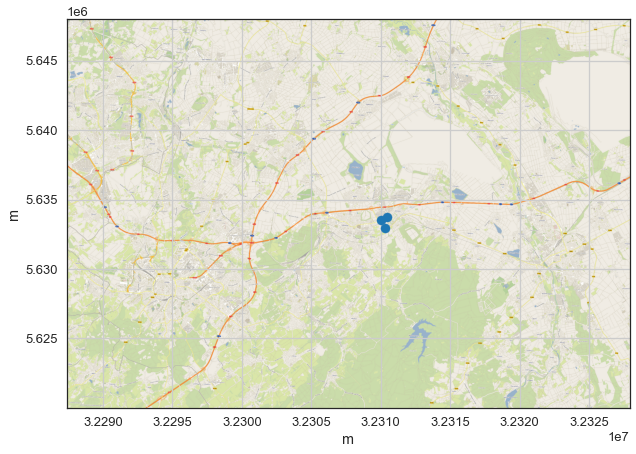

In [8]:
fig, ax1 = plt.subplots()
ax1.imshow(wms_map, extent= [32287388.59,32327922.38,5620005.3,5647999.26])
gdf.plot(ax=ax1)
ax1.grid()
ax1.set_xlabel('m')
ax1.set_ylabel('m')

# Extract Stratigraphic Column from Borehole Logs

Next to the coordinates of the Boreholes, the provided stratigraphic column can also be extracted for the use. 

# Load supplementary Data

In [41]:
with open('../../../gemgis/data/misc/symbols.txt', "r") as text_file:
    symbols = [(i, '') for i in text_file.read().splitlines()]

with open('../../../gemgis/data/misc/formations.txt', "r",encoding="utf-8") as text_file:
    formations = text_file.read().split()
    
formations = [(formations[i], formations[i+1]) for i in range(0,len(formations)-1,2)]
formations

[('Quartär', 'Quaternary'),
 ('Miozän', 'Miocene'),
 ('Oligozän', 'Oligocene'),
 ('Karbon', 'Carboniferous'),
 ('Krebs-Traufe-Formation', 'KrebsTraufeFM')]

In [42]:
with open('../../../BoreholeData.txt', "r") as text_file:
    data = text_file.read()

In [46]:
data[:100]

'Stammdaten    -     2521/ 5631/ 1         -          Bnum: 196747  .  .  Objekt / Name :B. 19  ESCHW'

In [44]:
df = gg.misc.stratigraphic_table_list_comprehension(data, 'GD', symbols, formations)

Schluff,schwachsandig,schwachtonigQuartär
GrobkiesQuartär
Sand,grauMiozän
Sand,schwarzMiozän
Sand,grauMiozän
BraunkohleMiozän
Ton,grauMiozän
Sand,grauMiozän
Sand,grünOligozän
TonKarbon
Tonstein,geschiefertKarbon
Schluff,schwachsandig,schwachtonigQuartär
GrobkiesQuartär
Sand,grauMiozän
BraunkohleMiozän
Sand,grauMiozän
Sand,blaugrauMiozän
Sand,grünMiozän
SandsteinKarbon
Schluff,schwachsandig,schwachtonigQuartär
KiesQuartär
BraunkohleMiozän
Sand,grauMiozän
BraunkohleMiozän
Sand,schwarzgrauMiozän
Ton,blauMiozän
Sand,grauMiozän
Sand,weißMiozän
Sand,hellgrauMiozän
Sand,weißMiozän
Sand,schwarzMiozän
Sand,grauMiozän
Sand,schwarzMiozän
Sand,grauMiozän
BraunkohleMiozän
Sand,grauMiozän
Sand,grünOligozän
TonOligozän
Sand,grünOligozän
Ton,Bemerkung:EinstufungunsicherKarbon
Schluff,schwachsandig,schwachtonigQuartär
Sand,grauQuartär
TonQuartär
GrobkiesQuartär
Sand,grauMiozän
Sand,schwarzMiozän
BraunkohleMiozän
Sand,grauMiozän
BraunkohleMiozän
Sand,grauLageausTonMiozän
Sand,hellgrünMiozän
Sand,grünOli

TonNichteingestuft
BraunkohleNichteingestuft
Sand,TonNichteingestuft
MutterbodenHolozän
TonPleistozän:Lösslehm
GrobkiesUnterpleistozän:ÄltereHauptterrassen
FeinsandOligozän-Miozän
FestgesteinKarbon
MutterbodenHolozän
GrobschluffPleistozän
KiesNichteingestuft
SandNichteingestuft
KiesNichteingestuft
TonNichteingestuft
Sand,tonigNichteingestuft
Sand,schwachkiesigNichteingestuft
TonNichteingestuft
Ton,sandigNichteingestuft
SandNichteingestuft
Sand,tonigNichteingestuft
Sand,kiesigNichteingestuft
SandNichteingestuft
Sand,tonigNichteingestuft
TonNichteingestuft
BraunkohleNichteingestuft
Braunkohle,sandigNichteingestuft
SandNichteingestuft
BraunkohleNichteingestuft
SandNichteingestuft
BraunkohleNichteingestuft
SandNichteingestuft
BraunkohleNichteingestuft
TonNichteingestuft
MutterbodenHolozän
Schluff,sandig,schwachtonigQuartär
SteineQuartär
Ton,KiesTertiär(PaläogenbisNeogen)
Ton,grauTertiär(PaläogenbisNeogen)
Ton,GrobkiesTertiär(PaläogenbisNeogen)
Feinkies,MittelkiesTertiär(PaläogenbisNeogen)


Grobsand,mittelsandig,schwachfeinsandig,schwachschluffig,grauMiozän?Hauptkies-Schichten
Grobsand,mittelsandig,schwachfeinsandig,schwachfeinkiesig,grauMiozän?Hauptkies-Schichten
Mittelsand,feinsandig,schwachgrobsandig,schwachtonig,grauMiozän?Hauptkies-Schichten
Mittelsand,grobsandig,schwachfeinsandig,schwachschluffig,grau,HolzresteMiozän?Hauptkies-Schichten
Mittelsand,grobsandig,schwachfeinsandig,schwachschluffig,grauMiozän?Hauptkies-Schichten
Mittelsand,grobsandig,schwachfeinsandig,grauMiozän?Hauptkies-Schichten
Mittelsand,feinsandig,schwachtonig,schwachschluffig,hellgrauMiozän
Schluff,tonig,braun,starkhumos,HolzresteMiozän
Schluff,tonig,schwachfeinsandig,gelbgrau,starkhumos,HolzresteMiozän
Schluff,tonig,schwachfeinsandig,hellgrauMiozän
Schluff,tonig,schwachfeinsandig,schwachmittelsandig,hellgrauMiozän
Mittelsand,grobsandig,schwachfeinsandig,schwachschluffigMiozän..---.mBraunkohle,mittelsandig,grobsandig,schwachfeinsandig,graubraunMiozän
Braunkohle,schwarzbraunMiozän
Schluff,tonig,grau

TonTertiär(PaläogenbisNeogen)
Schluff,sandig,tonigQuartär
GrobkiesQuartär
Sand,mitinkohltesHolzTertiär(PaläogenbisNeogen)
Sand,tonigTertiär(PaläogenbisNeogen)
SandTertiär(PaläogenbisNeogen)
Ton,sandigTertiär(PaläogenbisNeogen)
SandTertiär(PaläogenbisNeogen)
Braunkohle,sandigEinlagerungenausSandTertiär(PaläogenbisNeogen)
Braunkohle,sandigTertiär(PaläogenbisNeogen)
TonTertiär(PaläogenbisNeogen)
Schluff,sandig,tonigQuartär
GrobkiesQuartär
Sand,tonigTertiär(PaläogenbisNeogen)
GrobsandTertiär(PaläogenbisNeogen)
Sand,TonEinlagerungenausBraunkohle,geschichtetTertiär(PaläogenbisNeogen)
Sand,mitBraunkohleTertiär(PaläogenbisNeogen)
BraunkohleTertiär(PaläogenbisNeogen)
Braunkohle,tonigTertiär(PaläogenbisNeogen)
TonTertiär(PaläogenbisNeogen)
Schluff,sandig,schwachtonigQuartär
GrobkiesQuartär
Sand,tonigTertiär(PaläogenbisNeogen)
FeinsandTertiär(PaläogenbisNeogen)
GrobsandTertiär(PaläogenbisNeogen)
Sand,TonEinlagerungenausBraunkohleTertiär(PaläogenbisNeogen)
Braunkohle,Bemerkung:SchmierkohleTertiär(

Sandstein,tonig,braun,weich,geschiefertGerölleausQuarz,QuarzitNichteingestuft
Sandstein,rötlich,geschiefertGerölleausQuarzitNichteingestuft
Sandstein,rötlich,geschiefertKnolleausEisenerzNichteingestuft
Sandstein,gräulich,rötlich,hartwenigeGerölleausQuarz,QuarzitNichteingestuft
Sandstein,schwachmalachitisch,mitwenigAzurit,grauNichteingestuft
Konglomerat,mitwenigBleiglanz,schwachmalachitisch,mitwenigAzurit,hellgraugelbNichteingestuft
KonglomeratNichteingestuft
Sandstein,hellgelbbraunNichteingestuft
Grobsandstein,hellbraungrauNichteingestuft
Konglomerat,schwachmalachitisch,gelbbraunNichteingestuft
Konglomerat,gräulichNichteingestuft
Konglomerat,grauweißNichteingestuft
Grobsandstein,mitwenigBleiglanz,weißNichteingestuft
Konglomerat,kalzit(kalkspat)isch,gelbweißNichteingestuft
Grobsandstein,starktonig,rötlichNichteingestuft
Ton,rotbraun,geschiefertNichteingestuft
Humus,Schluff,schwachtonig,schwachfeinsandig,rotbraunNichteingestuft
Sandstein,tonig,braunrotNichteingestuft
Sandstein,graugelbNi

Tonstein,dunkelgrauschwarz,dünnbankig,bröckelig,vielPflanzenreste,stellenweiseEisenkrustenEinlagerungenausSteinkohle,schwarz,bröckelig,Bemerkung:starkglänzend;-cmmächtigKarbon:Krebs-Traufe-Formation
Steinkohle,schwarz,bröckelig,Bemerkung:starkglänzendKarbon:Krebs-Traufe-Formation
Schluffstein,grau,mittelbankig,keinePflanzenreste,klüftigKarbon:Krebs-Traufe-Formation
Steinkohle,schwarz,bröckelig,Bemerkung:starkglänzendKarbon:Krebs-Traufe-Formation
Schluffstein,grau,mittelbankig,teilweisePflanzenreste,klüftig,laminiertKarbon:Krebs-Traufe-Formation
Steinkohle,schwarz,bröckelig,Bemerkung:starkglänzendKarbon:Krebs-Traufe-Formation
Tonstein,dunkelgrauschwarz,dünnbankig,bröckelig,vielPflanzenreste,stellenweiseEisenkrusten,vereinzeltKonkretionenzahlreicheEinlagerungenausSteinkohle,schwarz,bröckelig,Bemerkung:starkglänzend;-cmmächtigKarbon:Krebs-Traufe-Formation
Tonstein,dunkelgrauschwarz,dünnbankig,teilweisegefaltet,vielPflanzenreste,stellenweiseEisenkrusten,vereinzeltKonkretionenwechsellagernd

Schluff,sandig,tonig,kiesigPleistozän:ÄltereHauptterrassen
Sand,grauCampanium:Vaals-Formation
Sand,gelbgrauKonkretionausSandsteinCampanium:Vaals-Formation
Sand,gelbKonkretionausSandsteinCampanium:Vaals-Formation
Sand,weißCampanium:Vaals-Formation
Ton,grauSantonium:Aachen-Formation,Aachen-Subformation
Sandstein,porösSantonium:Aachen-Formation,Aachen-Subformation
Ton,schwarzgrauSantonium:Aachen-Formation,Aachen-Subformation
Sand,tonigSantonium:Aachen-Formation,Aachen-Subformation
FeinsandSantonium:Aachen-Formation,Aachen-Subformation
Ton,schwarzgrauSantonium:Aachen-Formation,Hergenrath-Subformation
Sandstein,festSantonium:Aachen-Formation,Hergenrath-Subformation
Sand,grau,festSantonium:Aachen-Formation,Hergenrath-Subformation
Ton,grau,festSantonium:Aachen-Formation,Hergenrath-Subformation
Ton,schwarzSantonium:Aachen-Formation,Hergenrath-Subformation
Sand,festSantonium:Aachen-Formation,Hergenrath-Subformation
Ton,grauSantonium:Aachen-Formation,Hergenrath-Subformation
Ton,schwarzgrauSanton

Mittelkies,starkschluffig,dunkelbraun,Bemerkung:möglicherweisehumos,fossilerAh-Horizont;FeuersteinlehmPleistozän:ÄltereHauptterrassen
Mittelkies,schwachgrobkiesig,sandig,gelbbraun,Feuersteine,Bemerkung:einigegerundeteQuarzite;FeuersteinlehmPleistozän:ÄltereHauptterrassen
Mittelkies,starkschluffig,dunkelbraun,Bemerkung:möglicherweisehumos,fossilerAh-Horizont;FeuersteinlehmPleistozän:ÄltereHauptterrassen
Feinsand,mittelsandig,schwachfeinkiesig,gelbbraun,Bemerkung:weißpatinierteFeuersteingeröllePleistozän:ÄltereHauptterrassen
Feinsand,starktonig,grüngrau,gelbbraunPleistozän:ÄltereHauptterrassen
Mittelsand,feinsandig,gelbbraunPleistozän:ÄltereHauptterrassen
Feinsand,gelblich,grüngrau,Bemerkung:nachuntenhinfeinerwerdendPleistozän:ÄltereHauptterrassen
Feinsand,starkschluffig,hellgrüngrauwechsellagerndmitTon,starkschluffig,Bemerkung:immm-BereichlaminiertPleistozän:ÄltereHauptterrassen
Ton,schluffig,dunkelgrüngrauPleistozän:ÄltereHauptterrassen
Ton,starkschluffig,hellgrüngrauwechsellagerndmitS

Schluff,schwachtonig,hellbraun,kalkfrei,FeuersteineMaastrichtium:Gulpen-Formation,Orsbach-Subformation
Schluff,schwachtonig,weißlich,gelbbraun,kalkhaltig,FeuersteineMaastrichtium:Gulpen-Formation,Orsbach-Subformation
Mutterboden,kalkhaltig,FeuersteineHolozän
Schluff,schwachtonig,hellbraun,kalkfrei,Feuersteine,weichMaastrichtium:Gulpen-Formation,Orsbach-Subformation
Schluff,schwachtonig,hellgelbbraun,kalkhaltig,Feuersteine,weichbissteifLageausSteineMaastrichtium:Gulpen-Formation,Orsbach-Subformation
Mutterboden,mitKalkstein,kalkhaltig,FeuersteineHolozän
Schluff,schwachtonig,hellbraun,kalkfrei,Feuersteine,weichMaastrichtium:Gulpen-Formation,Orsbach-Subformation
Schluff,schwachtonig,hellbraun,kalkfrei,FeuersteineMaastrichtium:Gulpen-Formation,Orsbach-Subformation
Schluff,schwachtonig,hellgelbbraun,kalkhaltig,Feuersteine,weichbissteifMaastrichtium:Gulpen-Formation,Orsbach-Subformation
Schluff,schwachtonig,hellbraun,kalkfrei,weichMaastrichtium:Gulpen-Formation,Orsbach-Subformation
Schluff,s

Auffüllung,Bauschutt/Straßenaufbruch,bunt,schwerzubohrenHolozän:KünstlicheAuffüllungen
Kalkstein,hellgrau,hartOberdevon
Auffüllung,Bauschutt/Straßenaufbruch,grau,schwerzubohrenHolozän:KünstlicheAuffüllungen
Auffüllung,Asche/Schlacke,rot,braun,schwerzubohrenHolozän:KünstlicheAuffüllungen
Auffüllung,Schluff,schwachtonig,schwachsteinig,braun,schwerzubohrenHolozän:KünstlicheAuffüllungen
Auffüllung,Grobsand,schluffig,dunkelgrau,schwerzubohrenHolozän:KünstlicheAuffüllungen
Auffüllung,Schluff,tonig,grau,braun,schwerzubohrenHolozän:KünstlicheAuffüllungen
Auffüllung,Bauschutt/Straßenaufbruch,bunt,schwerzubohrenHolozän:KünstlicheAuffüllungen
Schluff,Feinsand,grau,braun,leichtzubohrenQuartär
Steine,Grobsand,grau,braun,schwerzubohrenQuartär
Schluff,tonig,grau,braunGerölleausSteineQuartär
Kalkstein,dunkelgrau,hartOberdevon
Auffüllung,Mutterboden,dunkelbraun,leichtzubohrenHolozän:KünstlicheAuffüllungen
Auffüllung,Bauschutt/Straßenaufbruch,steinig,bunt,schwerzubohrenHolozän:KünstlicheAuffüllungen
Auf

TonschieferNichteingestuft
Schluff,sandig,tonig,mittelkiesigQuartär
TonNichteingestuft
TonsteinNichteingestuft
Tonstein,geschiefertNichteingestuft
Schluff,sandig,tonigKarbon
TonKarbon
Tonstein,geschiefertKarbon
TonsteinKarbon
Tonstein,geschiefertKarbon
Ton,sandigNichteingestuft
TonNichteingestuft
Tonstein,geschiefertNichteingestuft
MutterbodenHolozän
TonNichteingestuft
Tonstein,geschiefertNichteingestuft
Schluff,schwachsandig,schwachtonig,schwachsteinig,braunPleistozän:Fließerde
Tonstein,starkzersetzt,VerwitterungszoneNamurium:Wilhelmine-Formation
Tonstein,zersetzt,stückigNamurium:Wilhelmine-Formation
Tonstein,sandigNamurium:Wilhelmine-Formation
Tonstein,stückig,StörungszoneNamurium:Wilhelmine-Formation
Tonstein,schwachsandig,stückig,entfestigtNamurium:Wilhelmine-Formation
Tonstein,schwachtonig,stückig,StörungszoneNamurium:Wilhelmine-Formation
Tonstein,schwachsandig,stückig,entfestigtNamurium:Wilhelmine-Formation
Tonstein,entfestigtNamurium:Wilhelmine-Formation
Tonstein,schwachtonig,St

Feinsand,schluffig,orangegelb,weißgrau,kalkfrei,streifig,dichtSantonium:Aachen-Formation,Hergenrath-Subformation
Schluff,feinsandig,bunt,kalkfrei,locker,halbfestbisfestzahlreicheGesteinsbruchstückeausChalcedon,Bemerkung:FeuersteinSantonium:Aachen-Formation,Hergenrath-Subformation
Mittelsand,Feinsand,rötlichgrau,grau,kalkfrei,lockerSantonium:Aachen-Formation,Hergenrath-Subformation
Schluff,tonig,schwachsteinig,dunkelbraun,(mittel)humos,kalkfreiPleistozän:Fließerde
Schluff,tonig,schwachsteinig,grau,kalkfreiPleistozän:Fließerde
Schluff,starktonig,steinig,grau,ockerbraun,kalkfreiPleistozän:Fließerde
Mittelsand,schwachtonig,starkkiesig,rotbraun,kalkfrei,gerundetMittelpleistozän:Mittelterrassen
Mittelsand,starkschluffig,tonig,rotbraun,ockerObererBuntsandstein(Röt)
Schluff,tonig,schwachsteinig,dunkelbraun,(mittel)humos,kalkfreiPleistozän:Fließerde
Schluff,tonig,schwachsteinig,grau,kalkfreiPleistozän:Fließerde
Schluff,starktonig,steinig,grau,ockerbraun,kalkfreiPleistozän:Fließerde
Schluff,star

Schluff,schwachtonig,schwachmergelig,hellbraun,bröckelig,erdfeucht,Bemerkung:steifOberpleistozän:Niederterrassen
Schluff,tonig,rötlichbraun,feucht,Bemerkung:weich-steifOberpleistozän:Niederterrassen
Schluff,tonig,steinig,rötlichbraun,bröckelig,vernäßt,Bemerkung:weichOberpleistozän:Niederterrassen
Schluff,schwachtonig,mergelig,hellbraun,vernäßt,Bemerkung:weichOberpleistozän:Niederterrassen
Schluff,schwachfeinsandig,hellgelbbraun,grau,bröckelig,trocken,Bemerkung:festMaastrichtium:Gulpen-Formation,Vylen-Subformation
Schluff,tonig,hellgelbbraun,erdfeucht,Bemerkung:steifMaastrichtium:Gulpen-Formation,Vylen-Subformation
Schluff,schwachtonig,schwachfeinsandig,braun,feuchtPleistozän:Lösslehm
Schluff,schwachtonig,schwachfeinsandig,hellgelbbraun,erdfeucht,Bemerkung:halbfestPleistozän:Lösslehm
Mergel,hellgelbbraun,gelb,trocken,Bemerkung:festMaastrichtium:Gulpen-Formation,Vylen-Subformation
Schluff,schwachtonig,braun,erdfeuchtPleistozän:Lösslehm
Mergel,hellgelbbraun,gelb,trockenMaastrichtium:Gulpe

Feinsandstein,graubraun,dunkelgrau,laminiert,schräggeschichtetwechsellagerndmitTonsteinTremadoc:MittlereWehebach-Formation
Schluff,tonig,feinkiesig,gelbgrau,weich,steifPleistozän:Fließerde
Schluff,starktonig,kiesig,graubraun,steifPleistozän:Fließerde
Feinkies,starkschluffig,grauPleistozän:Fließerde
Tonstein,dunkelgrau,entfestigt,bröckeligTremadoc:UntereWehebach-Formation
Schluff,schwachtonig,feinkiesig,gelbbraun,weich,steifPleistozän:Fließerde
Schluff,schwachtonig,starkkiesig,gelbbraun,steifPleistozän:Fließerde
Kies,schluffig,graubraunPleistozän:Fließerde
Tonstein,dunkelgrau,entfestigt,bröckeligTremadoc:UntereWehebach-Formation
Schluff,schwachtonig,kiesig,gelbbraun,steifPleistozän:Fließerde
Kies,schluffig,schwachtonig,gelbbraun,entfestigtPleistozän:Fließerde
Kies,schluffig,tonig,dunkelgrau,hartPleistozän:Fließerde
Tonstein,dunkelgrau,entfestigtLagenausFeinsandsteinTremadoc:UntereWehebach-Formation
Kies,schluffig,sandig,braun,entfestigtPleistozän:Fließerde
Tonstein,grau,gelbgrau,entfest

Schluff,feinsandig,steinig,gelbbraunPleistozän:Fließerde
Tonstein,schluffig,graubraun,dunkelgrau,zersetztübergehendinSchluffstein,tonig,graubraun,dunkelgrau,zersetztKarbon:UntereStolberg-Schichten
Feinsandstein,grau,hellgraubraunKarbon:UntereStolberg-Schichten
Feinsand,schluffig,steinig,gelbbraun,anthropogen,trockenHolozän:KünstlicheAuffüllungen
Schluff,gelblichbraun,kalkfrei,entkalkt,trockenPleistozän:Löss
Tonstein,schluffig,dunkelgrau,dunkelgraubraun,entfestigt,verwittertübergehendinSchluffstein,tonig,dunkelgrau,dunkelgraubraun,entfestigt,verwittertKarbon:UntereStolberg-Schichten
Schlacke,dunkelgrau,schwarzgrau,anthropogenHolozän:KünstlicheAuffüllungen
Sandstein,sandig,grau,rötlichgrau,schwachverwittert,fest,hartKarbon:UntereStolberg-Schichten
Mutterboden,feinsandig,schluffig,dunkelbraun,(mittel)humosHolozän
Schluff,gelblichbraun,kalkfrei,entkalkt,marmoriertPleistozän:Löss
Schluff,tonig,gelblichbraun,gelblichgrau,kalkfrei,marmoriertPleistozän:Lösslehm
Ton,schluffig,steinig,grau,graub

Tonstein,grau,hellgrau,weich,Bemerkung:Revin!GesteinsbruchstückeausSandstein,mitQuarz,grau,hartOberkambrium:Venn-Formation(Revin)
Bauschutt/Straßenaufbruch,schluffig,steinig,graubraun,dunkelgraubraunHolozän:KünstlicheAuffüllungen
Schluff,schwachtonig,steinig,gelbbraun,dichtzahlreicheGesteinsbruchstückeausFeinsandstein,schluffig,grünlichbraun,gelblichbraunzahlreicheGesteinsbruchstückeausSchluffstein,hellbraungelbPleistozän:Fließerde
Tonstein,mitwenigGlimmer,dunkelgrau,schwarzgrau,blättrig,weich,eisenschüssig,Bemerkung:eisenfarbeneFlächenOberkambrium:Schevenhütte-Formation(Revin)
Mutterboden,sandig,schluffig,dunkelbraun,schwarzbraun,schwachhumos,lockerHolozän
Schluff,tonig,steinig,hellgelbbraun,hellbraungelbzahlreicheGesteinsbruchstückeausTonsteinPleistozän:Fließerde
Tonstein,hellgrau,gebleicht,weich,blättrig,rostfleckigOberkambrium:Schevenhütte-Formation(Revin)
Mutterboden,schluffig,sandig,dunkelbraun,schwachhumos,lockerHolozän
Schluff,tonig,steinig,hellgelbgrauzahlreicheGesteinsbruchst

Feinsand,Mutterboden,schwarzbraun,terrestrisch,starkhumos,locker,Bemerkung:qh/fS,h/swbn/boHolozän
Schluff,starksteinig,weißgelb,glazigen,kalkfrei,Bemerkung:qp/U,x/be/flPleistozän:Fließerde
Schluffstein,rotbraun,grün,terrestrisch,verwittert,Bemerkung:du,ds/^u,vw/robn,gn/vzUnterdevon:Kalltal-Formation
Feinsand,Mutterboden,schwachschluffig,graubraun,terrestrisch,humos,Bemerkung:qh/fS,h,u/grbn/boHolozän
Feinsand,Mittelsand,schluffig,schwachsteinig,hellgelb,ocker,glazigen,Bemerkung:qp/fS,mS,u,x/hge,oc/flPleistozän:Fließerde
Feinsand,Mittelsand,schwachsteinig,mitMittelsandstein,rostfarben,ocker,terrestrisch,verwittert,Bemerkung:du,dg/fS,mS,x,b,^fs,vw,^ms,vw/rf,oc,be,dbn,fl/vzGesteinsbruchstückausFeinsandsteinUnterdevon:Kalltal-Formation
Feinsand,Mutterboden,hellgraubraun,terrestrisch,schwachhumos,Bemerkung:qh/fS,h/hgrbn/boHolozän
Schluff,schwachfeinsandig,schwachsteinig,weißgelb,glazigen,glimmerhaltig,Bemerkung:qp/U,fs,x,"gl"/be/flPleistozän:Fließerde
Feinsand,schluffig,steinig,ocker,weißgel

MutterbodenHolozän
Schluff,schwachfeinsandig,schwachtonig,gelbPleistozän
Grobkies,rötlichPleistozän
Ton,buntTertiär(PaläogenbisNeogen)
Ton,sandig,buntTertiär(PaläogenbisNeogen)
Grobkies,grauTertiär(PaläogenbisNeogen)
Kies,sandig,grauTertiär(PaläogenbisNeogen)
Grobkies,rotTertiär(PaläogenbisNeogen)
Sand,grauTertiär(PaläogenbisNeogen)
Braunkohle,mitinkohltesHolzTertiär(PaläogenbisNeogen)
Grobkies,rötlichTertiär(PaläogenbisNeogen)
BraunkohleTertiär(PaläogenbisNeogen)
Schluff,schwachfeinsandig,schwachtonigPleistozän
KiesUnterpleistozän
Kies,tonigUnterpleistozän
Mergel,kiesigNeogen
BraunkohleNeogen
Schluff,schwachfeinsandig,schwachtonigPleistozän
KiesUnterpleistozän
TonNeogen
MergelNeogen
Schluff,schwachfeinsandig,schwachtonigPleistozän
SandPleistozän
TonNeogen
KiesNeogen
TonNeogen
Schluff,schwachfeinsandig,schwachtonigPleistozän
KiesLagenausTonUnterpleistozän
Ton,braungrauNeogen
Schluff,schwachfeinsandig,schwachtonigPleistozän
KiesUnterpleistozän
SandUnterpleistozän
Ton,SandNeogen
TonNeoge

SandNichteingestuft
Bauschutt/StraßenaufbruchNichteingestuft
Schluff,tonig,sandigNichteingestuft
Kies,tonigNichteingestuft
Grobkies,weißNichteingestuft
Ton,sandig,grauNichteingestuft
Grobkies,schwarzNichteingestuft
Kohle,tonigNichteingestuft
KohleNichteingestuft
TonEinlagerungausKohleNichteingestuft
KohleNichteingestuft
Ton,grauNichteingestuft
Sand,grün,glaukonitischNichteingestuft
Schluff,tonig,sandigNichteingestuft
Feinsand,tonigNichteingestuft
Grobkies,tonigNichteingestuft
Grobkies,weißNichteingestuft
KohleNichteingestuft
TonNichteingestuft
Sand,tonig,grün,glaukonitischNichteingestuft
Kohle,tonigNichteingestuft
Ton,grauNichteingestuft
Kohle,inkohltesHolz,tonigNichteingestuft
Ton,grauNichteingestuft
KohleNichteingestuft
Kohle,sandigNichteingestuft
SandNichteingestuft
Schluff,tonig,sandigNichteingestuft
Kies,tonigNichteingestuft
Kies,sandigNichteingestuft
Kies,weiß,festNichteingestuft
Grobkies,tonigNichteingestuft
Grobkies,festNichteingestuft
Ton,schwarz,festNichteingestuft
KohleNicht

Feinsand,schwachschluffig,grau,fest,erdfeuchtTertiär(PaläogenbisNeogen)
Schluff,feinsandig,schwachtonig,schwachsteinig,braun,kalkfrei,umgelagert,trockenPleistozän:Lösslehm
Schluff,feinsandig,schwachtonig,hellbraun,kalkfrei,umgelagert,erdfeuchtübergehendinSchluff,feinsandig,tonig,hellbraunPleistozän:Lösslehm
Schluff,feinsandig,schwachtonig,hellbraun,kalkhaltig,umgelagertPleistozän:Löss
Schluff,steinig,kiesig,tonig,rot,kalkfrei,umgelagertbestehendausSandstein,Bemerkung:KantengerundetMittelpleistozän
Sand,schluffig,rötlichgelbTertiär(PaläogenbisNeogen)
Sand,schwachschluffig,gelbbraun,gelbgrau,streifigTertiär(PaläogenbisNeogen)
Mutterboden,schwachhumos,erdfeuchtHolozän
Schluff,feinsandig,tonig,erdfeuchtHolozän:Schwemmlöss
Schluff,feinsandig,tonig,schwachkiesig,erdfeuchtHolozän:Schwemmlöss
Sand,Kies,rötlich,schwarz,locker,naßPleistozän:Niederterrassen
Sand,braun,dunkelbraunEinlagerungausSchluffOligozän:Köln-Formation
Schluff,tonig,mitwenigBraunkohle,dunkelbraunOligozän:Köln-Formation
Sand,o

Ton,schwachschluffig,schwachsteinig,starksandig,grau,ockerPleistozän:Fließerde
Ton,schwachschluffig,steinig,starksandig,grauPleistozän:Fließerde
Mittelsand,Feinsand,schwachkiesig,weißgelbTertiär(PaläogenbisNeogen):Köln-Formation
Schluff,tonig,dunkelbraun,humos,umgelagertPleistozän:Lösslehm
Schluff,tonig,braun,humos,umgelagertPleistozän:Lösslehm
Schluff,tonig,graubraunPleistozän:Lösslehm
Schluff,schwachtonig,sandig,kiesig,ockerbraunPleistozän:Hauptterrassen
Feinsand,schwachschluffig,kiesig,schwachsteinig,graubraun,schwarzPleistozän:Hauptterrassen
Schluff,schwachtonig,sandig,kiesig,graubraunPleistozän:Hauptterrassen
Ton,sandig,schluffig,graubraunOligozän-Miozän
Ton,schluffig,dunkelgrauOligozän-Miozän
Mutterboden,graubraunHolozän
Schluff,schwachtonig,hellgraubraunGerölleausSandstein,QuarzPleistozän?Fließerde
Mittelsand,grauweiß,weißTertiär(PaläogenbisNeogen)
Mittelsand,gräulichweißTertiär(PaläogenbisNeogen)
Mutterboden,braunHolozän
Schluff,schwachtonig,gelbbraunPleistozän:Lösslehm
Schluff

Feinsand,schwachschluffig,gelb,grau,kalkfreiOligozän-Miozän:Köln-Formation
Feinsand,hellgrau,kalkfreiOligozän-Miozän:Köln-Formation
Ton,schluffig,sandig,schwachkiesig,dunkelbraun,(mittel)humos,kalkfreiMittelpleistozän:Hauptterrassen
Ton,schluffig,sandig,schwachkiesig,ockerbraun,grau,kalkfreiMittelpleistozän:Hauptterrassen
Ton,schwachschluffig,schwachkiesig,grau,kalkfreiMittelpleistozän:Hauptterrassen
Feinsand,schwachschluffig,grau,hell,kalkfrei,fest,Bemerkung:mitFe-Bändern,keinBohrfortschrittOligozän-Miozän:Köln-Formation
Schluff,tonig,sandig,schwachkiesig,dunkelbraun,(mittel)humos,kalkfreiPleistozän:Fließerde
Schluff,tonig,sandig,kiesig,braun,kalkfreiPleistozän:Fließerde
Ton,schluffig,sandig,kiesig,ockerbraun,kalkfreiMittelpleistozän:Hauptterrassen
Ton,schluffig,sandig,kiesig,ockerbraun,kalkfreiMittelpleistozän:Hauptterrassen
Mittelsand,schwachschluffig,tonig,kiesig,ockerbraun,kalkfreiMittelpleistozän:Hauptterrassen
Mittelsand,schluffig,kiesig,grau,ocker,kalkfreiMittelpleistozän:Haupt

In [45]:
df[:1000].head(50)

,Index,Name,X,Y,Z,Altitude,Depth,formation
0,GD0001,B.19ESCHWEILER,32310019.32,5633520.32,125.30,130.00,70.30,Quaternary
1,GD0001,B.19ESCHWEILER,32310019.32,5633520.32,66.50,130.00,70.30,Miocene
2,GD0001,B.19ESCHWEILER,32310019.32,5633520.32,60.90,130.00,70.30,Oligocene
3,GD0001,B.19ESCHWEILER,32310019.32,5633520.32,59.70,130.00,70.30,Carboniferous
4,GD0002,B.16ESCHWEILER,32310327.14,5632967.35,117.80,122.00,37.61,Quaternary
5,GD0002,B.16ESCHWEILER,32310327.14,5632967.35,84.40,122.00,37.61,Miocene
6,GD0002,B.16ESCHWEILER,32310327.14,5632967.35,84.39,122.00,37.61,Carboniferous
7,GD0003,B35WEIßWEILER-ESCHWEILER,32310419.57,5633764.29,119.20,125.00,109.60,Quaternary
8,GD0003,B35WEIßWEILER-ESCHWEILER,32310419.57,5633764.29,20.30,125.00,109.60,Miocene
9,GD0003,B35WEIßWEILER-ESCHWEILER,32310419.57,5633764.29,15.60,125.00,109.60,Oligocene


# Plot of classified boreholes